# Haar like features
Haar-like features are digital image features used in object recognition.

![img/haarExample.png](img/haarExample.png)

Each feature is computed by integrating the gray scale image.
The sum of the pixels which lie within the white rectangles are subtracted from the sum of pixels in the grey rectangles.

Viola jones uses 5 types of features:
 - Two rectangle feature, vertical (feature A).
 - Two rectangle feature, horizontal (feature B).
 - Three rectangle feature, horizontal (feature C).
 - Three rectangle feature, vertical (similar to feature C, except it is vertical).
 - Four rectangle feature, (feature D).
 
Each feature can have different size and location within the detection window. The detection window has a size of 24x24 pixels which gives a total number of 180,000 possible features.

Let's demonstrate the process of computing the feature value on a simple example.

First we have to load the image and extract the detection frame.
The detection frame is simply a square region that has a size of 24x24 pixels. Haar like feature will be applied inside this region.

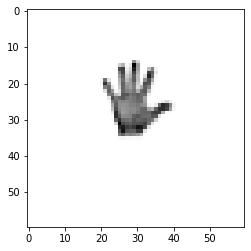

In [1]:
from ViolaJones.plot import showImage
import cv2

img = cv2.imread('testImage.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (60, 60), interpolation = cv2.INTER_AREA)

showImage(img)

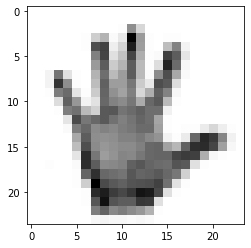

In [2]:
from ViolaJones.dataset import cropImage

pos = (18, 12)
size = (24, 24)
cropImg = cropImage(img, pos[0], pos[1], size[0], size[1])

showImage(cropImg)

Now let's generate the Haar like feature. For the purpose of this demonstration it will be represented as a matrix. Value of 1 will represent a white region, value of 0 will represent black region of the feature.

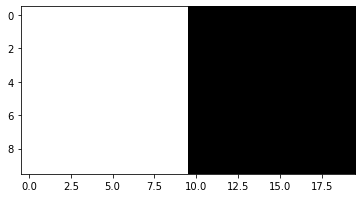

In [3]:
import numpy as np

#generate example haar feature
def genHaarMagic(size):
    haar = np.ones(size)
    for x in range(0, size[0]):
        for y in range(int(size[1]/2), size[1]):
            haar[x][y] = 0
    return haar

haar = genHaarMagic((10, 20))
showImage(haar)

Now let's apply the Haar feature. In order to do this we can crop the detection window and then treat the haar feature as a mask.

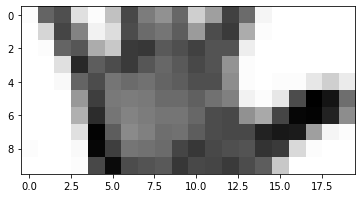

In [4]:
size = (haar.shape[1], haar.shape[0]) # rows and then columns DOUH!
areaUnderHaar = cropImage(cropImg, 2, 9, size[0], size[1])
showImage(areaUnderHaar)

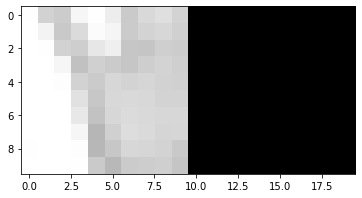

In [5]:
maskedImage = areaUnderHaar*(haar==1)
showImage(maskedImage)

We can compute the integral by taking the sum of all pixels of the masked image.

In [6]:
whiteInt = np.sum(maskedImage)
print(whiteInt)

22387


Then we have to repeat the process for the area under black rectangle.

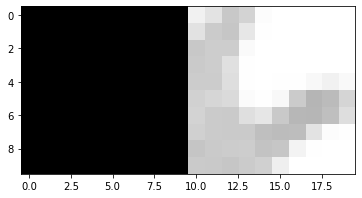

In [7]:
maskedImage = areaUnderHaar*(haar == 0)
showImage(maskedImage)

In [8]:
darkInt = np.sum(maskedImage)
print(darkInt)

22807


And finally substract the values of the integrals to get the feature value.

In [9]:
haarValue = int(whiteInt) - int(darkInt)
print(haarValue)

-420


# Integral image
The above method is however incredibly inefficient and will not be used here.
Value of the integral of the rectangular region can be computed really fast using so called integral image. 
Integral image is an image where value of the pixel in any given location (x,y) is a sum of all pixels inside the rectangle (0,0), (0, x), (x,y), (0, y). 

$$ I(x,y) = \sum_{x' \leq x \\ y' \leq y}^{} i(x', y')$$
Where I(x,y) is an integral image function and i(x, y) is an image function.

In practice integrl image is computed using a formula:
$$ I(x,y) = i(x,y) + I(x, y-1) + I(x-1, y) - I(x-1, y-1) $$

This formula is implemented openCV function integral.

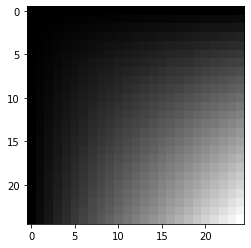

In [10]:
integralImage = cv2.integral(cropImg)
showImage(integralImage)

We can use integral image to very quickly compute the integral over the rectangular region.

![img/integralImageUsage.png](img/integralImageUsage.png)

The value of the integral image at location 1 is the sum of the pixels in rectangle A. The value at locations 2 is A+B at location 3 is A+C and at location 4 is A+B+C+D. The sum within D can be computed as 4+1-(2+3).

# Computing Haar like features using integral image

Integral image is implemented inside IntegralImage class. Method sumRegion takes two opposite corners of the rectangular region and returns integral value.

Let's use this class to compute the value of the haar like features used previously and see if the results match.

In [11]:
from ViolaJones.integralImage import IntegralImage

position = (2, 9)
width = 20
height = 10

#define corners
top_left = position
bottom_right = (position[0] + width, position[1] + height)

integralImage = IntegralImage(cropImg)
first = integralImage.sumRegion(top_left, (int(top_left[0] + width / 2), top_left[1] + height))
second = integralImage.sumRegion((int(top_left[0] + width / 2), top_left[1]), bottom_right)
score = first - second

print("Score is: " + str(score))

Score is: -420


As we can see the score is exactly the same as from the naive method.

All Haar like features are implemented by the class Haar.

# Hand image dataset

In order to train and build a classifier we will need two datasets. Training dataset for training a classifier and test dataset for evaluating performance. Datasets should contain a number of detection frames containing hands and a number of detection windows that do not contain hands. We will be using supervised learning so each sample must have a label indicating whether it contains hand or not.

Because we do not have resources to build a proper dataset we will use a very small dataset containing 20 images of hand on a smooth surface and 20 images of the surface itself.

Dataset is included in our repository under directory dataset.
All samples are stored in two directories.
Directory named 'Positive' contains positive samples. Directory 'Negative' contains background images.

Let's load images and take a quick look at the samples.

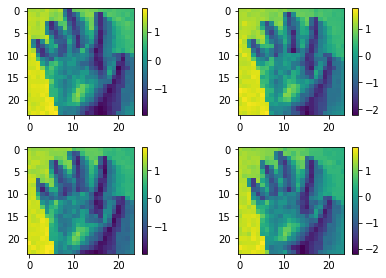

In [13]:
from ViolaJones.plot import showGrid
from ViolaJones.dataset import HandsDataset

DATASET_DIR = "dataset"

dataset = HandsDataset(DATASET_DIR)
dataset.loadFiles()
dataset.toGrayScale()
dataset.genNegativeSamples()
dataset.resize()
dataset.normalize()

showGrid(2, 2, dataset.positiveSamples[:4], colorBars=True)

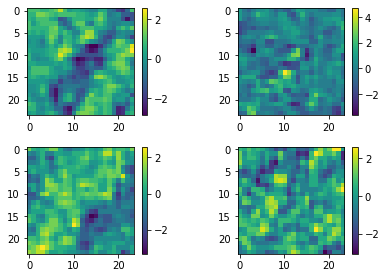

In [14]:
showGrid(2, 2, dataset.negativeSamples[:4], colorBars=True)

# Preparing dataset for training

They are several steps required to prepare our dataset for training.

 - Convert all images to grayscale.
 - Select random detection frames from negative samples.
 - Resize all samples to the size of the detection frame (24x24).
 - Variance normalize all samples (substract mean value of the image, and divide by STD).
 - Perform a split into training and test dataset (2/3 samples for training and 1/3 for testing).
 
All of those operations are implemented inside dataset.py file and they are performed automatically. All we have to do is to call a function buildDataset.

In [15]:
from ViolaJones.dataset import buildDataset
import random

#seed Pseudo Random Number Generator (PRNG)
#constant seed is used to ensure that results are exactly the same on each run
random.seed(42)

dataset = buildDataset(DATASET_DIR)

Training samples are stored inside trainingDataset attribute, test samples are stored inside testDataset attribute.

In [16]:
print(dataset.trainingDataset[:3])

[(<ViolaJones.integralImage.IntegralImage object at 0x7f18bc353040>, 1), (<ViolaJones.integralImage.IntegralImage object at 0x7f18bc353700>, 1), (<ViolaJones.integralImage.IntegralImage object at 0x7f18bc353fd0>, 1)]


As we can see, each sample consists out of an integral image of detection frame and a label telling whether the sample is positive or negative.

# Building a weak classifier
Now we have to build a classifier using haar like featues. The classifier shall compute the value of the feature and use it to determine whether the detecion window contains hand or not. Of course a single feature is not a reliable indicator of the hand presence. For this reason we will call this classifier weak.

$$
h_j(x) = 
\begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
      1 & \text{if } p_j f_j(x) < p_j 	\theta_j\\
      0 & \text{otherwise}
    \end{array}
\end{array}
$$

A weak classifier h(x) consists of a feature f(x), a threshold thetha and a parity p indicating the direction of the inequality sign.

Weak classifier is implemented by the class WeakClassifier class.

Let's demonstrate the operation of the classifier by taking two samples from the training dataset, one positive and one negative, and manually setting the classifier parameters.

In [17]:
from ViolaJones.haar import Haar, FeatureType

#watch out for changing a seed!
intImage_positive = dataset.trainingDataset[0][0]
intImage_negative = dataset.trainingDataset[1][0]

#build a haar like feature used inside the classifier
awesomeHaar = Haar(FeatureType.TWO_HORIZONTAL, (2, 9), 20, 10)

#compute the scores 
print("Positive score is : " + str(awesomeHaar.computeScore(intImage_positive, 0, 0)))
print("Negative score is : " + str(awesomeHaar.computeScore(intImage_negative, 0, 0)))

Positive score is : 89.56123531982303
Negative score is : 87.28888801811263


Now let's use those scores to setup threshold and the polarity of the classifier.

In [18]:
from ViolaJones.classifier import WeakClassifier

classifier = WeakClassifier(awesomeHaar, 0, 1) #threshold=20, polarity=1 
print("Positive sample score: " + str(classifier.classify(intImage_positive, 0, 0)))
print("Negative sample score: " + str(classifier.classify(intImage_negative, 0, 0)))

Positive sample score: False
Negative sample score: False


As we can see, the classifier succesfully distinguished those two samples.

# Strong classifier
To improve the performance we can construct the strong classifier by combining the results of many weak classifiers.

$$
h(x) = 
\begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
      1 & \text{if } \sum_{t=0}^{T} a_t h_t(x) \ge  0.5 \sum_{t=0}^{T} a_t\\
      0 & \text{otherwise}
    \end{array}
\end{array}
$$

Strong classifier h(x) returns a positive result if a weighted sum of results of weak classifiers is greater or equal to to the half of the maximum possible sum.

Strong classifier is implemented by the class StrongClassifier.

# Training a strong classifier with Adaptive Boosting

Now the problem is to select a number of best Haar like features and determine their optimal polarity and threshold.
For this a learning algorithm called Adaptive Boosting (AdaBoost) will be used.

The algorithm is as follows:

 - Given example images (x1, y1), (x2, y2) ... (xn, yn) where x is an image and y is either 0 when sample is negative or 1 when sample is positive.
 - Initialize weights of each sample
 $$
 w_i = 
\begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
      1 \over {2p} & \text{if sample is positive}\\
      1 \over {2n} & \text{if sample is negative}
    \end{array}
\end{array}
 $$ where p is a number of positive samples and n is a number of negative samples.
 - For t = 0, 1, 2, .... T (T beeing a number of features that we want to include in our strong classifier.
    1. Normalize the weights so they form a probability distribution.
    2. For each feature $j$ train a weak classifier $h_j$. The error is evaluated with respect to sample weights.
    $$
    \epsilon_j = \sum_{i}^{} w_i|h_j(x_i) - y_i|
    $$
    3. Choose the classifier $h_t$, with the lowest error $\epsilon_t$.
    4. Evaluate each sample $i$ in a training dataset using choosen classifier $h_t$.
    $$
    e_i = 
    \begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
     0 & \text{if sample was classified correctly}\\
     1 & \text{if sample was classified incorrectly}
    \end{array}
\end{array}
    $$
    5. Update sample weights:
    $$
    w_{t+1, i} = w_{t, i}\beta_t^{1-e_i}
    $$
    $$
    \beta_t = \frac{\epsilon_t} {1 - \epsilon_t}
    $$
    6. Choose weak classifier weight.
    $$
    a_t = ln \frac{1}{\beta_t}
    $$
    
Now let's implement this algorithm.
First thing that we have to do is to generate all possible Haar like features. For 24x24 they are 180,000 possible features some parameters were however restricted to simplify the implementation.
This is performed by the function genAllFeatures from module ViolaJones.train which basically returns all possible features from the specified parameter space.

In [19]:
from ViolaJones.train import genAllFeatures

#setup parameters
DETECTION_FRAME_WIDTH = 24
DETECTION_FRAME_HEIGHT = 24

MIN_FEATURE_WIDTH = 1
MAX_FEATURE_WIDTH = 24

MIN_FEATURE_HEIGHT = 1
MAX_FEATURE_HEIGHT = 24

print("Generate haar like features ....")
features = genAllFeatures(DETECTION_FRAME_WIDTH, DETECTION_FRAME_HEIGHT, MIN_FEATURE_WIDTH, MAX_FEATURE_WIDTH, MIN_FEATURE_HEIGHT, MAX_FEATURE_HEIGHT)
print(str(len(features)) + " features generated!")

Generate haar like features ....
136656 features generated!


Now let's initialise weights.

In [20]:
from ViolaJones.train import initWeights

weights = initWeights(dataset.positive_train_count, dataset.negative_train_count, dataset.trainingDataset)

print("Example weights: " + str(weights[:10])) #print first 10 weights
weights = np.array(weights)

Example weights: [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333]


Next step is the implementation of the weight normalization. Weight normalization is done in order to keep the sum of all weights at 1. The weights are normalized using a formula:
$$
w_{t,i} = \frac{w_{t,i}} {\sum_{j=0}^{n} w{t, j}}
$$

In [21]:
def normWeights(weights):
    return weights * (1. / np.sum(weights))

Now it's time to implement weak classifier training.
This is computationally the most expensive part of the training process. However, there is an efficient way to find the optimal threshold and polarity for a single weak classifier using the weights. First we take the feature and compute it's value for all samples. Then we sort the weights and computed feature values by a feature value. Then we iterate throught the sorted features and compute error if the threshold was choosen for the given feature. Since features are sorted by value of the feature, error can be represented using a formula:
$$
e = S_{\text{positive}} - S_{\text{negative}} + T_{\text{negative}} 
$$
$$
\text{or}
$$
$$
e = S_{\text{negative}} - S_{\text{positive}} + T_{\text{positive}}
$$ Whichever is smaller. Where $T_{\text{positive}}$ represents a total sum of positive sample weights. $T_{\text{negative}}$ represents a total sum of negative sample weights. $S_{\text{positive}}$ represents a sum of positive sample weights seen so far and $S_\text{negative}$ represents a sum of negative sample weights seen so far.

This way, we can evaluate the error of each possible threshold in constant time $O(1)$ and the error of all thresholds in linear time $O(n)$. The threshold is set to the value of the feature at which the error is a minimum. The polarity is determined by how many positive examples and negative examples lie left (less than) and right of the threshold (greater than). If there are more positive examples left of the threshold, $p=1$. Otherwise, $p = -1$.

![img/errorSorting.png](img/errorSorting.png)
In this example, the numbers indicate the feature values and the size of the bubbles indicates their relative weights. Clearly, the error will be minimized when any feature with a value less than 9 is classified as blue. That corresponds to a threshold of 9 with a polarity of 1.

Weak training is implemente by the function trainWeakClassifier from module ViolaJones.train.
It takes the training dataset, sample weights and HaarLike feature.

In [22]:
from ViolaJones.train import trainWeakClassifier

classifier = trainWeakClassifier(dataset.trainingDataset, weights, features[42])
print("Classifier threshold: " + str(classifier.threshold))
print("Classifier polarity: " + str(classifier.polarity))

Classifier threshold: -0.12421810626983643
Classifier polarity: -1


Now we can determine error $\epsilon_t$ for a trained classifier.

In [23]:
from ViolaJones.train import computeError
err = computeError(dataset.trainingDataset, normWeights(weights), classifier)
print("Classifier error: " + str(err))

Classifier error: 0.3359649122807015


The last step is to train a strong classifier using adptive boosting.
Adptive boosting is implemented by the adaBoost function.
It takes the training dataset, weights, list of features and a number of features
that will be included in the strong classifier.

In [24]:
from ViolaJones.train import adaBoost
import pickle
features = genAllFeatures(DETECTION_FRAME_WIDTH, DETECTION_FRAME_HEIGHT, MIN_FEATURE_WIDTH, MAX_FEATURE_WIDTH, MIN_FEATURE_HEIGHT, MAX_FEATURE_HEIGHT)
weights = initWeights(dataset.positive_train_count, dataset.negative_train_count, dataset.trainingDataset)
classifiers, classifierWeights = adaBoost(dataset.trainingDataset, weights, features, 3, threadCount=11)

Training classifier 1/3....
Found feature with error: 0.001
Classifier has weight: 6.906754778648554
Training classifier 2/3....
Found feature with error: 0.001
Classifier has weight: 6.906754778648554
Training classifier 3/3....
Found feature with error: 0.001
Classifier has weight: 6.906754778648554


Now we just have to build the strong classifier.

In [25]:
from ViolaJones.classifier import StrongClassifier

strongClassifier = StrongClassifier(classifiers, classifierWeights)

# Testing accuracy

Now let's quickly evaluate the accuracy of our strong classifier. In order to do that we will use our training dataset and verify the percentage of correctly labeled samples.

In [26]:
def testAccuracy(testDataset, classifier):
    samplesCorrectly = 0
    for sample in testDataset:
        if classifier.classify(sample[0], 0, 0) == sample[1]:
            samplesCorrectly += 1
    return samplesCorrectly/len(testDataset)
        
print("Accuracy is " + str(testAccuracy(dataset.testDataset, strongClassifier)))

Accuracy is 1.0


We can also determine and plot the amount of false positives and false negatives depending on the number of weak classifiers.

# The attentional cascade

Next step is building the attentional cascade.

![img/cascade.png](img/cascade.png)

The idea behind the attention cascade is to quickly reject most of the windows that do not contain hands before they will be processed by computationally expensive classifier with a large number of features.

The cascade architecture has also interesting implications for the performance of the individual classifiers. Because the activation of each classifier depends entirely on the behavior of its predecessor, the false positive rate for an entire cascade is:
$$
F = \prod_{i=1}^{K} f_{i}
$$
Similarly, the detection rate is:
$$
D = \prod_{i=1}^{K} d_{i}
$$
Thus, to match the false positive rates typically achieved by other detectors, each classifier can get away with having surprisingly poor performance. For example, for a 32-stage cascade to achieve a false positive rate of 10−6, each classifier need only achieve a false positive rate of about 65%. At the same time, however, each classifier needs to be exceptionally capable if it is to achieve adequate detection rates. For example, to achieve a detection rate of about 90%, each classifier in the aforementioned cascade needs to achieve a detection rate of approximately 99.7%.

This is quite convinient since the amount of false positives increase with the detection rate as shown on the Receiver Operating Characteristic curve (ROC):
![img/ROC.png](img/ROC.png)

In [27]:
class Cascade():
    def __init__(self, strongClassifiers):
        self.strongClassifiers = strongClassifiers
    
    def setScale(self, scale):
        for i in range(0, len(self.strongClassifiers)):
            self.strongClassifiers[i].setScale(scale)
    
    def classify(self, int_image, x, y):
        for classifier in self.strongClassifiers:
            if classifier.classify(int_image, x, y) == False:
                return False
        return True

Now let's train the attentional cascade. In this example we will limit the number of weak classifiers per stage to 10 and number of stages to 10 since training times measured in days would not be great. Viola Jones algorithm is really fast but it takes very long time to train.

The algorithm used for training is as follows:
```
f = the maximum acceptable false positive rate per layer.
d = the minimum acceptable detection rate per layer.
Ftarget = target overall false positive rate.
P = set of positive examples.
N = set of negative examples.

F(0) = 1.0
D(0) = 1.0
i = 0
while F(i) > Ftarget
    increase i
    n(i) = 0; F(i)= F(i-1)

    while F(i) > f × F(i-1)
        increase n(i)
        use P and N to train a classifier with n(I) features using AdaBoost
        Evaluate current cascaded classifier on validation set to determine F(i) and D(i)
        decrease threshold for the ith classifier (i.e. how many weak classifiers need to accept for strong classifier to accept)
            until the current cascaded classifier has a detection rate of at least d × D(i-1) (this also affects F(i))
    N = ∅
    if F(i) > Ftarget then 
        evaluate the current cascaded detector on the set of non-face images 
        and put any false detections into the set N.

```

False positive rate is measured using formula:
$$
f_i = \frac {FP} {FP + TN}
$$

Detection rate is measured using formula:
$$
d_i = \frac {TP} {TP + FN}
$$

Since have to change strong classifier threshold we have also to redefine the formula.
$$
h(x) = 
\begin{array}{cc}
  \Bigg\{ & 
    \begin{array}{cc}
      1 & \text{if } \sum_{t=0}^{T} a_t h_t(x) \ge \sigma + 0.5 \sum_{t=0}^{T} a_t \\
      0 & \text{otherwise}
    \end{array}
\end{array}
$$

Where sigma is a threshold offset.

If you haven't picked up a favourite book to read yet, now is definietly the right moment for that since you will have plenty of time before the training is completed (around 24h). This implementation of viola jones algorithm is not very fast but python3 allowed for rapid development of this example. Better solution would be multithreaded C++ program posibbly with GPU acceleration. The best option would be to construct a training program that would run on the computational cluster. But it would take a long time to write. Also there are ready to use tools shipped with OpenCV3 which are probably the best option.

In [28]:
from ViolaJones.dataset import HandsDataset

# define settings
f = 0.6
d = 0.90
Ftarget = 0.001

# build dataset
# first let's build a new dataset manually and do not shuffle/zip
dataset = HandsDataset(DATASET_DIR)
dataset.loadFiles()
dataset.toGrayScale()
dataset.genNegativeSamples()
dataset.resize()
dataset.normalize()
dataset.integrate()

# extract positive and negative samples
P = dataset.positiveSamples.copy()
N = dataset.negativeSamples.copy()

trainedClassifiers = []

# function that evaluates cascade
def evaluateCascade(N, P, cascade):
    FN = 0 # False Negatives
    FP = 0 # False Positives
    TN = 0 # True Negatives
    TP = 0 # True Positives
        
    for negativeSample in N:
        if cascade.classify(negativeSample, 0, 0) == 0:
            TN += 1
        else:
            FP += 1
        
    for positiveSample in P:
        if cascade.classify(positiveSample, 0, 0) == 1:
            TP += 1
        else:
            FN += 1
            
    return FN, FP, TN, TP

F = [1.0]
D = [1.0]
i = 0
while F[i] > Ftarget:
    i += 1
    n = 0 # number of features in the current classifier
    F.append(F[i-1]) # F(i)= F(i-1)
    D.append(0)
    print("Started layer " + str(len(trainedClassifiers)+1) + " training! F[i]=" + "{0:.6f}".format(F[i]) + " Target F=" + "{0:.6f}".format(Ftarget))
    print("len(N)=" + str(len(N)))

    # prepare training dataset, adaBoost method accepts a single dataset so we have to mix
    P_COPY = P.copy()
    N_COPY = N.copy()
    mixed = list(zip(P_COPY, np.ones(len(P_COPY), dtype=int)))
    mixed += list(zip(N_COPY, np.zeros(len(N_COPY), dtype=int)))    
    while F[i] > f * F[i-1]:
        n += 1
        
        # train strong classifier using n features
        print("Starting to train strong classifier with " + str(n) + " features")
        weights = initWeights(len(P), len(N), mixed)
        features = genAllFeatures(DETECTION_FRAME_WIDTH, DETECTION_FRAME_HEIGHT, MIN_FEATURE_WIDTH, MAX_FEATURE_WIDTH, MIN_FEATURE_HEIGHT, MAX_FEATURE_HEIGHT)
        classifiers, classifierWeights = adaBoost(mixed, weights, features, n, verbose=False, threadCount=11)
        strongClassifier = StrongClassifier(classifiers, classifierWeights)
        
        cascade = Cascade(trainedClassifiers + [strongClassifier])
        
        # evaluate cascade, validation set is not available so we will use training set instead
        FN, FP, TN, TP = evaluateCascade(N, P, cascade)
        
        # compute False positive rate and Detection rate
        F[i] = FP/(FP + TN)
        D[i] = TP/(TP + FN)
        
        # decrease threshold until detection rate of at least d × D(i-1)
        offsetSettingStep = 0.01
        while D[i] < d*D[i-1]:
            strongClassifier.setThresholdOffset(strongClassifier.thresholdOffset-offsetSettingStep)
            cascade = Cascade(trainedClassifiers + [strongClassifier])
            FN, FP, TN, TP = evaluateCascade(N, P, cascade)
            F[i] = FP/(FP + TN)
            D[i] = TP/(TP + FN)
        if strongClassifier.thresholdOffset != 0:
            print("Classifier threshold adjusted by " + "{0:.6f}".format(strongClassifier.thresholdOffset))
        print("Strong classifier generated n="+str(n)+" F[i]="+"{0:.6f}".format(F[i])+" D[i]="+"{0:.6f}".format(D[i]))
        
    # add strong classifier to the strong classifier list
    trainedClassifiers.append(strongClassifier)
    
    # evaluate the current cascaded detector on the set of non-face images 
    # and put any false detections into the set N.
    N = []
    for nSample in dataset.negativeSamples:
        if cascade.classify(nSample, 0, 0) == 0:
            N.append(nSample)


Started layer 1 training! F[i]=1.000000 Target F=0.001000
len(N)=56
Starting to train strong classifier with 1 features
Strong classifier generated n=1 F[i]=0.000000 D[i]=1.000000


Now let's verify the accuracy of the cascade.

In [29]:
cascade = Cascade(trainedClassifiers)
dataset.split()
print("Accuracy of the cascade is " + str(testAccuracy(dataset.testDataset, cascade)))

Accuracy of the cascade is 1.0


# Applying classifier to the image

Now let's apply our cascade classifier to the image and try to find the hand.
In order to do that we have to convert he image into the grayscale, normalize variance, compute integral image and then slide the detection frame throught the image. We will do multiple passes with different detection frame scales in order to capture hands with different sizes.

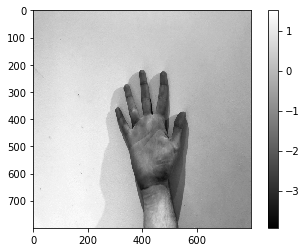

In [43]:
from ViolaJones.dataset import normalize
import matplotlib.pyplot as plt

exampleImage = cv2.imread('testMagic.jpg')
exampleImage = cv2.cvtColor(exampleImage, cv2.COLOR_BGR2GRAY)

exampleImage = cv2.resize(exampleImage, (800, 800), interpolation=cv2.INTER_AREA)
height, width = exampleImage.shape[:2]

exampleImage = normalize([exampleImage])[0]
plt.imshow(exampleImage ,cmap='gray')
plt.colorbar()
plt.show()

In [48]:
from math import ceil
boundingBoxes = []

baseFrameSize = 24
scale = 1.0
scaleStep = 2
endScale = height/(1.25*24)

while scale < endScale:
    x = 0
    y = 0
    step = int(baseFrameSize*scale)
    
    while x<(width - ceil(baseFrameSize*scale)-1):
        while y<(height - ceil(baseFrameSize*scale)-1):
            # very ugly workaround for bug in haar features scaling
            frame = exampleImage[y:y+ceil(24*scale), x:x+ceil(24*scale)]
            frame = cv2.resize(frame, (24, 24), interpolation=cv2.INTER_AREA)
            if cascade.classify(IntegralImage(frame), 0, 0) == True:
                boundingBoxes.append((x, y, step,  step))
            y += step

        y = 0
        x += step

    scale += scaleStep


Now let's draw the bounding boxes.

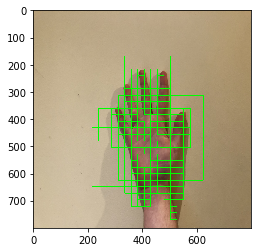

In [49]:
dispImage = cv2.imread('testMagic.jpg') # load example image once again so we get the color
dispImage = cv2.cvtColor(dispImage, cv2.COLOR_BGR2RGB)
dispImage = cv2.resize(dispImage, (800, 800), interpolation = cv2.INTER_AREA)

for box in boundingBoxes:
      cv2.rectangle(dispImage, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 255, 0), 2)
        
plt.imshow(dispImage)
plt.show()

As we can see the classifier succesfully learned to distinguish that anything that is not flat like a wall is a hand.
This due to the fact that our dataset is really rubbish. Proper training would require a large number of images and backgrounds. But for this demonstration this example will also do.

# References

[1] https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf - Original paper by Paul Viola, Michael Jones.

[2] https://github.com/Simon-Hohberg/Viola-Jones - Parts of the shown code were adapted from here.

[3] https://medium.com/datadriveninvestor/understanding-and-implementing-the-viola-jones-image-classification-algorithm-85621f7fe20b

[4] https://medium.com/swlh/the-intuition-behind-facial-detection-the-viola-jones-algorithm-29d9106b6999